In [22]:
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image
from pycocotools import mask as mask_utils
from skimage.draw import polygon2mask
import random
# set seed
random.seed(0)

In [2]:
DATA_DIR = Path.cwd().parents[1] / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
IMAGES_DIR = RAW_DATA_DIR / "train2017"

In [3]:
with open(RAW_DATA_DIR / "lvis_v1_train.json") as f:
    data = json.load(f)

In [4]:
cat_imgs_anns = {}
imgs_cat_anns = {}

for annotation in tqdm(data["annotations"]):
    cat_id = annotation["category_id"]
    img_id = annotation["image_id"]
    id = annotation["id"]
    if cat_id not in cat_imgs_anns:
        cat_imgs_anns[cat_id] = {}
    if img_id not in imgs_cat_anns:
        imgs_cat_anns[img_id] = {}
    if img_id not in cat_imgs_anns[cat_id]:
        cat_imgs_anns[cat_id][img_id] = []
    if cat_id not in imgs_cat_anns[img_id]: 
        imgs_cat_anns[img_id][cat_id] = []
    cat_imgs_anns[cat_id][img_id].append(annotation)
    imgs_cat_anns[img_id][cat_id].append(annotation)

100%|██████████| 1270141/1270141 [00:02<00:00, 569281.88it/s]


In [5]:
def get_pil_image(img):
    img_name = os.path.basename(img["coco_url"])
    img_path = IMAGES_DIR / img_name
    return Image.open(img_path)

In [6]:
tot = 0
for img in imgs_cat_anns:
    tot += len(imgs_cat_anns[img])

tot / len(imgs_cat_anns)

3.6317462872781423

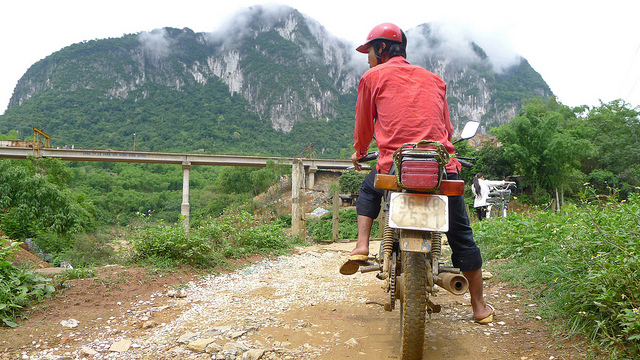

In [7]:
img = data["images"][0]

get_pil_image(img)

In [8]:
imgs_cat_anns[img["id"]][459][0]["segmentation"][0]

[476.39,
 319.82,
 478.9,
 320.34,
 481.94,
 319.82,
 484.72,
 318.23,
 486.83,
 317.44,
 490.27,
 314.92,
 491.99,
 313.47,
 492.12,
 311.88,
 492.78,
 310.17,
 491.99,
 308.98,
 490.8,
 307.52,
 489.48,
 306.6,
 488.29,
 305.8,
 486.3,
 304.88,
 485.77,
 303.42,
 487.36,
 303.29,
 488.68,
 303.82,
 490.4,
 304.35,
 490.93,
 305.14,
 493.71,
 307.79,
 494.5,
 308.84,
 494.5,
 309.77,
 494.63,
 311.88,
 494.5,
 314.26,
 494.1,
 315.45,
 493.18,
 317.04,
 492.65,
 319.82,
 492.25,
 321.67,
 490.53,
 322.99,
 488.68,
 323.25,
 485.38,
 324.44,
 481.54,
 324.71,
 479.3,
 324.05,
 476.39,
 322.72,
 476.39,
 319.82]

In [9]:
def ann_to_rle(ann, h, w):
        """Convert annotation which can be polygons, uncompressed RLE to RLE.
        Args:
            ann (dict) : annotation object

        Returns:
            ann (rle)
        """
        segm = ann["segmentation"]
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = mask_utils.frPyObjects(segm, h, w)
            rle = mask_utils.merge(rles)
        elif isinstance(segm["counts"], list):
            # uncompressed RLE
            rle = mask_utils.frPyObjects(segm, h, w)
        else:
            # rle
            rle = ann["segmentation"]
        return rle

def ann_to_mask(ann, h, w):
    """Convert annotation which can be polygons, uncompressed RLE, or RLE
    to binary mask.
    Args:
        ann (dict) : annotation object

    Returns:
        binary mask (numpy 2D array)
    """
    rle = ann_to_rle(ann, h, w)
    return mask_utils.decode(rle)

In [72]:
import numpy as np
import cv2

def draw_masks(image_data, cats=None):
    image = np.array(get_pil_image(image_data))
    masked_image = image.copy()

    colors = {}
    for cat in imgs_cat_anns[image_data["id"]]:
        colors[cat] = np.random.randint(0, 255, size=(3,)).tolist()

    masks = {}
    for cat in imgs_cat_anns[image_data["id"]]:
        masks[cat] = []
        for ann in imgs_cat_anns[image_data["id"]][cat]:
            masks[cat].append(ann_to_mask(ann, image_data["height"], image_data["width"]))

    for cat in masks:
        if cats is None or cat in cats:
            for mask in masks[cat]:
                masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                        np.asarray(colors[cat], dtype='uint8'),
                                        masked_image)

    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

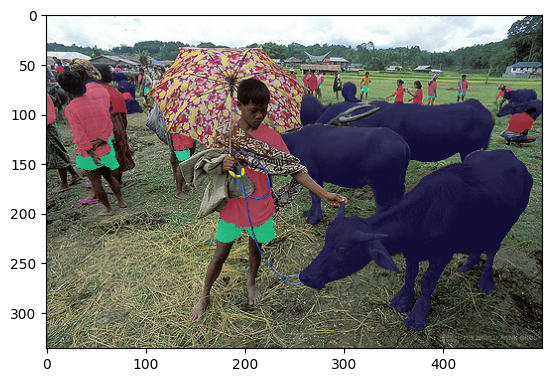

In [16]:
segmented_image = draw_masks(image_data=data["images"][2])

import matplotlib.pyplot as plt
plt.imshow(segmented_image)

In [99]:
query_image = data["images"][3]
query_image_anns = imgs_cat_anns[query_image["id"]]

In [100]:
M = 5

In [104]:
# take random int from 1 to len(query_image_anns)
C = random.randint(1, len(query_image_anns))
# take random C categories from query_image_anns
C_categories = random.sample(query_image_anns.keys(), min(M, C))
C_categories

/tmp/ipykernel_13793/2153096810.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  C_categories = random.sample(query_image_anns.keys(), min(M, C))


[698, 705, 296]

In [105]:
# partition C_categories into M sets (with replacement if necessary)
sublists = []

while len(C_categories) > 0:
    sublist_size = random.randint(1, len(C_categories))
    sublist = C_categories[:sublist_size]
    sublists.append(sublist)
    C_categories = C_categories[sublist_size:]

sublists = sublists[:M]
sublists

[[698, 705, 296]]

In [106]:
def get_image_ids_intersection(sublist, query_image_id):
    possible_examples = []
    for cat in sublist:
        possible_examples.append(set())
        for image_id in cat_imgs_anns[cat]:
            if image_id != query_image_id:
                possible_examples[-1].add(image_id)
    return set.intersection(*possible_examples)

In [107]:
M_examples = []
M_classes = []

for sublist in sublists:
    intersection = get_image_ids_intersection(sublist, query_image["id"])
    while len(intersection) < 1:
        sublist = sublist[:-1]
        intersection = get_image_ids_intersection(sublist, query_image["id"])
    
    M_examples.append(intersection)
    M_classes.append(sublist)

M_base_examples = [random.choice(list(cat_examples)) for cat_examples in M_examples]
while len(M_base_examples) < M:
    x = random.randint(0, len(M_examples) - 1)
    M_base_examples.append(random.choice(list(M_examples[x])))
    M_classes.append(M_classes[x])

In [108]:
M_base_examples

[364205, 536514, 177277, 85320, 454388]

In [109]:
def get_image_by_id(image_id):
    for image in data["images"]:
        if image["id"] == image_id:
            return image

In [110]:
def get_cat_by_id(cat_id):
    for cat in data["categories"]:
        if cat["id"] == cat_id:
            return cat["name"]

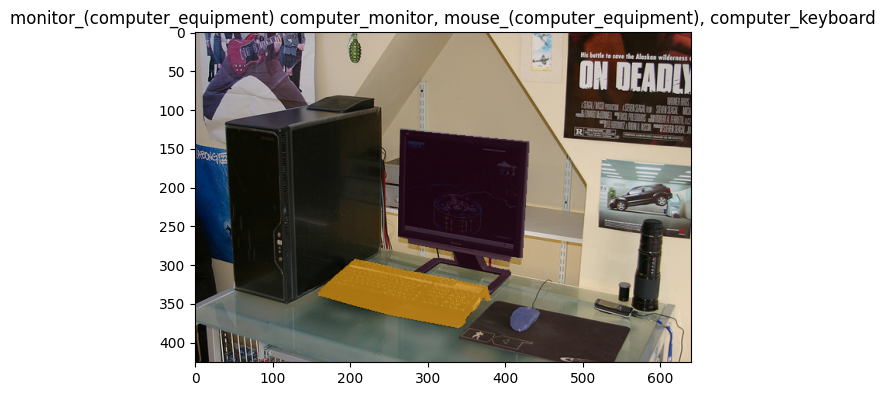

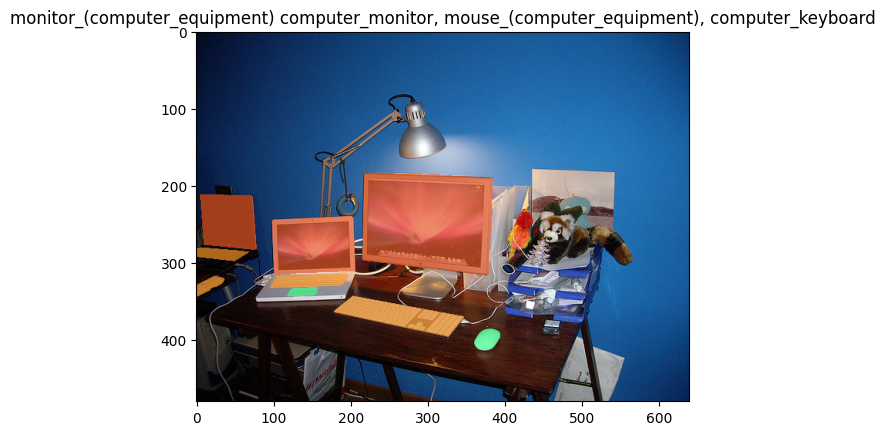

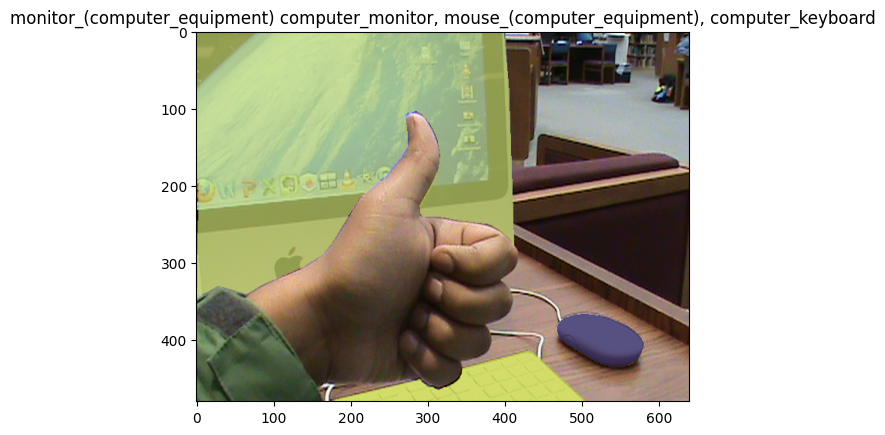

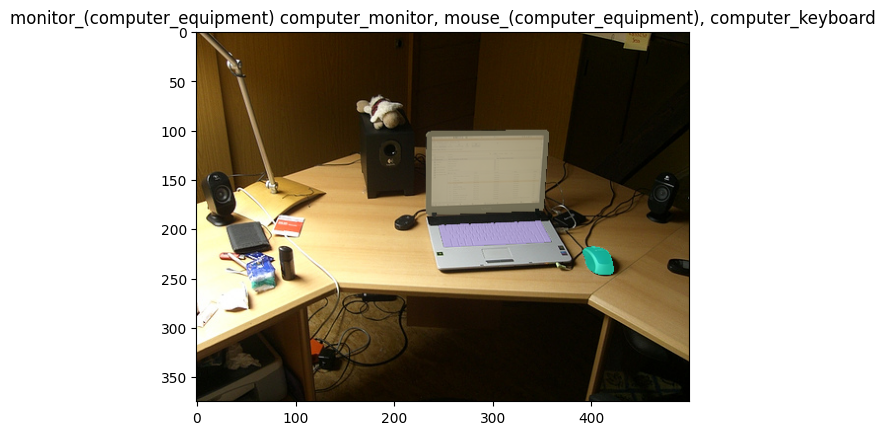

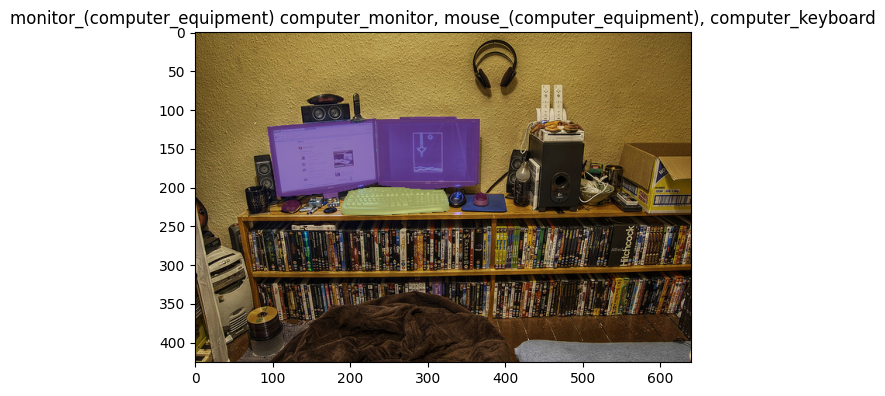

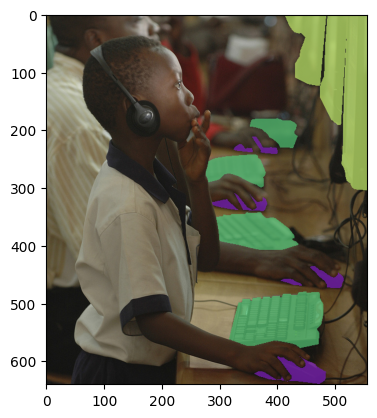

In [111]:
# show query image and M base examples
example_images = [get_image_by_id(x) for x in M_base_examples]
example_images.append(query_image)

segmented_images = [draw_masks(image_data=image, cats=[x for y in sublists for x in y]) for image in example_images]

for idx, image in enumerate(segmented_images):
    plt.figure()
    plt.imshow(image)
    title = []
    if idx < len(M_classes):
        for cat in M_classes[idx]:
            title.append(get_cat_by_id(cat))
    plt.title(", ".join(title))